In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import shutil
import random
from PIL import Image
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils import class_weight

2025-06-27 15:05:48.214374: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 15:05:48.239785: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv("./metadata/HAM10000_metadata.csv")
df.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [ ]:
def redimensionar(size, input_base, ruta_salida):  
# Ruta donde se guardarán las imágenes redimensionadas
  output_base = ruta_salida
  os.makedirs(output_base, exist_ok=True)

  # Tamaño
  size = (size, size)

  for img_name in os.listdir(input_base):
    try:
        img_path = os.path.join(input_base, img_name)
        img = Image.open(img_path).convert('RGB')
        img = img.resize(size, Image.LANCZOS)
        img.save(os.path.join(output_base, img_name))
        print(f'Imagen {img_name} redimensionada y guardada en {output_base}')
    except Exception as e:
        print(f'Error en {img_name}: {e}')
      

#redimensionar(224, './archive(1)/HAM10000_images_part_1', "./redimension")
redimensionar(224, './archive(1)/HAM10000_images_part_2', "./redimension")


In [25]:
df = pd.read_csv("./archive(1)/HAM10000_metadata.csv")

# Ruta donde están las imágenes
img_dir = "./redimension"

# Ruta donde se crearán las carpetas por categoría
output_dir = "./redimension_categorias"
os.makedirs(output_dir, exist_ok=True)

# Crear carpetas por cada categoría en dx
for categoria in df['dx'].unique():
    os.makedirs(os.path.join(output_dir, categoria), exist_ok=True)

for idx, row in df.iterrows():
    categoria = row['dx']
    img_name = row['image_id'] + ".jpg"
    src = os.path.join(img_dir, img_name)
    dst = os.path.join(output_dir, categoria, img_name)
    
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"Imagen no encontrada: {src}")


In [16]:
def dividir_train_test(base_path, source_path):
  train_path = os.path.join(base_path, 'train')
  test_path = os.path.join(base_path, 'test')

  os.makedirs(train_path, exist_ok=True)
  os.makedirs(test_path, exist_ok=True)

  # Dividir cada clase
  # Iterar sobre cada clase del dataset redimensionado
  for class_name in tqdm(os.listdir(source_path)):
      class_dir = os.path.join(source_path, class_name)
      if not os.path.isdir(class_dir):
          continue
    
    # Obtener imágenes y mezclarlas aleatoriamente
      images = os.listdir(class_dir)
      random.shuffle(images)

      n_total = len(images)
      n_train = int(n_total * 0.8)

      train_images = images[:n_train]
      test_images = images[n_train:]

    # Crear subcarpetas por clase

      os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
      os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

      # Copiar imágenes a las carpetas de train y test
      for img in train_images:
          shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, class_name, img))

      for img in test_images:
          shutil.copy(os.path.join(class_dir, img), os.path.join(test_path, class_name, img))

dividir_train_test("./redimension_categorias_completado_train_test", "./redimension_categorias_completado")


100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


In [15]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

origen = "redimension_categorias"  # carpeta original con clases
destino = "redimension_categorias_completado"  # carpeta destino
limite = 500

# Crear carpeta destino
os.makedirs(destino, exist_ok=True)

# Aumentos a aplicar
augmentador = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

for clase in os.listdir(origen):
    ruta_origen = os.path.join(origen, clase)
    ruta_destino = os.path.join(destino, clase)
    os.makedirs(ruta_destino, exist_ok=True)

    imagenes = os.listdir(ruta_origen)
    
    # Copiar todas las imágenes originales primero
    for imagen in imagenes:
        shutil.copy(os.path.join(ruta_origen, imagen), os.path.join(ruta_destino, imagen))

    total_actual = len(imagenes)
    faltan = limite - total_actual

    if faltan > 0:
        # Crear un generador solo para esta clase
        temp_gen = augmentador.flow_from_directory(
            origen,
            classes=[clase],
            target_size=(224, 224),
            batch_size=1,
            save_to_dir=ruta_destino,
            save_prefix='aug_',
            save_format='jpeg'
        )

        # Generar imágenes nuevas hasta llegar al límite
        print(f"🔄 Aumentando {clase}: generando {faltan} nuevas imágenes...")
        for i in range(faltan):
           next(temp_gen)


print("✅ Clases minoritarias completadas hasta 500.")


Found 115 images belonging to 1 classes.
🔄 Aumentando df: generando 385 nuevas imágenes...
Found 142 images belonging to 1 classes.
🔄 Aumentando vasc: generando 358 nuevas imágenes...
Found 327 images belonging to 1 classes.
🔄 Aumentando akiec: generando 173 nuevas imágenes...
✅ Clases minoritarias completadas hasta 500.


In [17]:
# Augmentación para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Sin augmentación para validación
test_datagen = ImageDataGenerator(rescale=1./255)

# Directorios
train_dir = "redimension_categorias_completado_train_test/train"
test_dir = "redimension_categorias_completado_train_test/test"

# Generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 8744 images belonging to 7 classes.
Found 2187 images belonging to 7 classes.


In [18]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

# Fine-tuning parcial: congelar capas menos profundas
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Modelo completo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 clases
])

In [19]:
# Compilación
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('model_augmented.h5', save_best_only=True)
]

In [20]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,426 (16.73 MB)

 Trainable params: 1,683,255 (6.42 MB)

 Non-trainable params: 2,701,171 (10.30 MB)

In [21]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=callbacks
)

/home/felipep/anaconda3/envs/data-science/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.5058 - loss: 1.7442

274/274 ━━━━━━━━━━━━━━━━━━━━ 275s 963ms/step - accuracy: 0.5059 - loss: 1.7439 - val_accuracy: 0.6132 - val_loss: 1.4568
Epoch 2/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.5708 - loss: 1.5325

274/274 ━━━━━━━━━━━━━━━━━━━━ 257s 937ms/step - accuracy: 0.5708 - loss: 1.5324 - val_accuracy: 0.6132 - val_loss: 1.4192
Epoch 3/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 271s 988ms/step - accuracy: 0.5708 - loss: 1.5208 - val_accuracy: 0.6132 - val_loss: 1.4197
Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.5882 - loss: 1.4725

274/274 ━━━━━━━━━━━━━━━━━━━━ 262s 955ms/step - accuracy: 0.5882 - loss: 1.4725 - val_accuracy: 0.6132 - val_loss: 1.3411
Epoch 5/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 270s 985ms/step - accuracy: 0.6051 - loss: 1.4258 - val_accuracy: 0.6132 - val_loss: 1.3709
Epoch 6/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 268s 979ms/step - accuracy: 0.6044 - loss: 1.4131 - val_accuracy: 0.6132 - val_loss: 1.3791
Epoch 7/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 269s 982ms/step - accuracy: 0.6030 - loss: 1.4215 - val_accuracy: 0.6132 - val_loss: 1.3525


69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 588ms/step
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00       100
         bcc       0.00      0.00      0.00       103
         bkl       0.00      0.00      0.00       220
          df       0.00      0.00      0.00       100
         mel       0.00      0.00      0.00       223
          nv       0.61      1.00      0.76      1341
        vasc       0.00      0.00      0.00       100

    accuracy                           0.61      2187
   macro avg       0.09      0.14      0.11      2187
weighted avg       0.38      0.61      0.47      2187



/home/felipep/anaconda3/envs/data-science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felipep/anaconda3/envs/data-science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felipep/anaconda3/envs/data-science/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

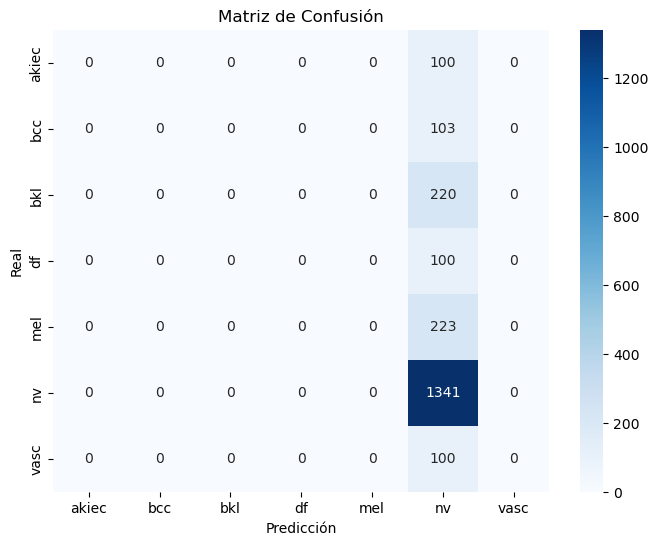

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Predicción
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# Reporte
print(classification_report(y_true, y_pred, target_names=class_names))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [25]:
model.save('modelo_final_balanceado.h5')
